# Catfish Sales Predictions


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import io
import requests

In [3]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [6]:
#better way to do it 
url="https://raw.githubusercontent.com/ritvikmath/Time-Series-Analysis/master/catfish.csv" 
s=requests.get(url).content 
catfish=pd.read_csv(io.StringIO(s.decode('utf-8')), parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [7]:
catfish = catfish.asfreq(pd.infer_freq(catfish.index))

In [9]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
lim_catfish = catfish[start_date:end_date]

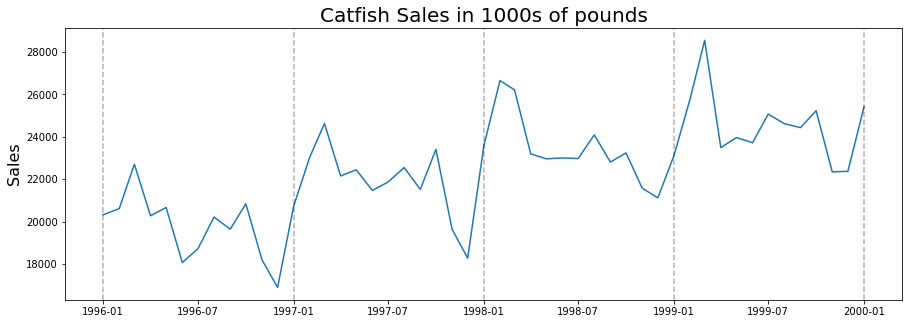

In [11]:
plt.figure(figsize=(15,5))
plt.plot(lim_catfish)
plt.title('Catfish Sales in 1000s of pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(1996, 2001):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.3)

# Remove trend

In [13]:
first_diff = lim_catfish.diff()[1:]

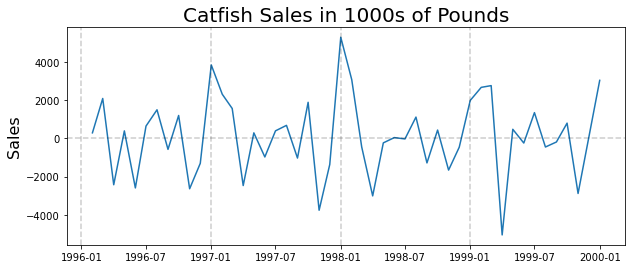

In [14]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

# ACF

C:\Users\Jonathan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


<BarContainer object of 20 artists>

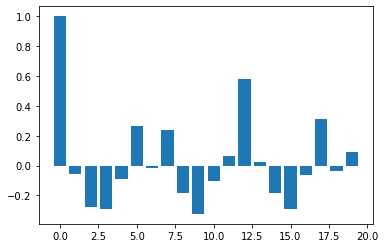

In [15]:
acf_vals = acf(first_diff)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

# PACF

C:\Users\Jonathan\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


<BarContainer object of 15 artists>

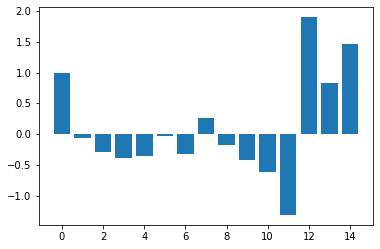

In [16]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

# Discussion
- Based on the ACF, a seasonal MA process should be used as the significance of lags is insignificant after the first lag
- Based on the PACF, a seasonal AR process should be used

# Get training and testing sets


In [17]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

train_data = lim_catfish[:train_end]
test_data = lim_catfish[train_end + timedelta(days=1):test_end]

# Fit the SARIMA Model

In [18]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [19]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.21266531944274902


C:\Users\Jonathan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [20]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -365.635
Date:                              Thu, 28 Jan 2021   AIC                            737.269
Time:                                      15:35:30   BIC                            742.482
Sample:                                  01-01-1996   HQIC                           739.180
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8249      0.121      6.845      0.000       0.589       1.061
ma.S.L12      -0.51

In [22]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

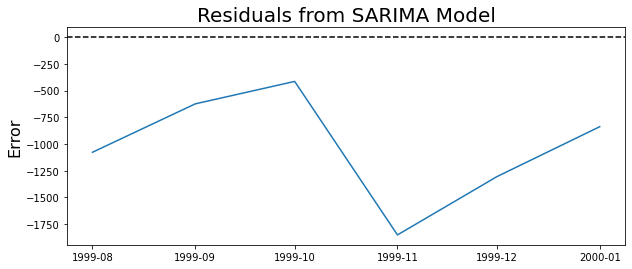

In [23]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

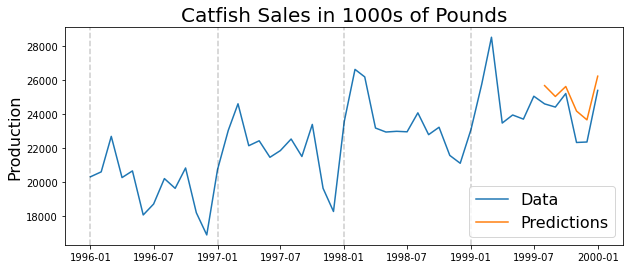

In [25]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [26]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0433


In [27]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1122.23755695348


In [29]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_catfish[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

C:\Users\Jonathan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\Jonathan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [30]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

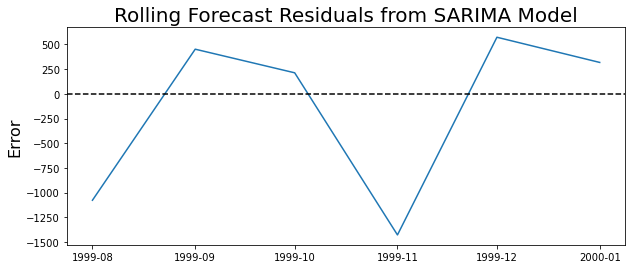

In [31]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

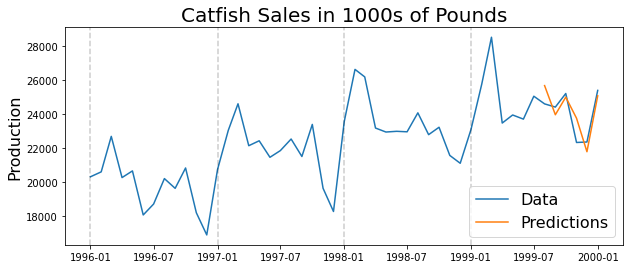

In [33]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [34]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0288


In [35]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 803.9733619136064
